In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import numpy as np
import librosa
from glob import glob
import soundfile as sf
import random

In [3]:
files = glob('../speech-bahasa/LibriSpeech/test-clean/*/*/*.flac')
len(files)

2620

In [4]:
def read_flac(file):
    data, old_samplerate = sf.read(file)
    if len(data.shape) == 2:
        data = data[:, 0]
    return data, old_samplerate

def sox_augment_low(
    y,
    min_bass_gain = 5,
    reverberance = 1,
    hf_damping = 1,
    room_scale = 1,
    stereo_depth = 1,
):
    from pysndfx import AudioEffectsChain
    apply_audio_effects = (
        AudioEffectsChain()
        .lowshelf(gain = min_bass_gain, frequency = 300, slope = 0.1)
        .reverb(
            reverberance = reverberance,
            hf_damping = hf_damping,
            room_scale = room_scale,
            stereo_depth = stereo_depth,
            pre_delay = 20,
            wet_gain = 0,
            wet_only = False,
        )
    )
    y_enhanced = apply_audio_effects(y)

    return y_enhanced


def sox_augment_high(
    y,
    min_bass_gain = 5,
    reverberance = 1,
    hf_damping = 1,
    room_scale = 1,
    stereo_depth = 1,
):
    from pysndfx import AudioEffectsChain
    apply_audio_effects = (
        AudioEffectsChain()
        .highshelf(gain = -min_bass_gain, frequency = 300, slope = 0.1)
        .reverb(
            reverberance = reverberance,
            hf_damping = hf_damping,
            room_scale = room_scale,
            stereo_depth = stereo_depth,
            pre_delay = 20,
            wet_gain = 0,
            wet_only = False,
        )
    )
    y_enhanced = apply_audio_effects(y)

    return y_enhanced


def sox_augment_combine(
    y,
    min_bass_gain_low = 5,
    min_bass_gain_high = 5,
    reverberance = 1,
    hf_damping = 1,
    room_scale = 1,
    stereo_depth = 1,
):

    from pysndfx import AudioEffectsChain
    apply_audio_effects = (
        AudioEffectsChain()
        .lowshelf(gain = min_bass_gain_low, frequency = 300, slope = 0.1)
        .highshelf(gain = -min_bass_gain_high, frequency = 300, slope = 0.1)
        .reverb(
            reverberance = reverberance,
            hf_damping = hf_damping,
            room_scale = room_scale,
            stereo_depth = stereo_depth,
            pre_delay = 20,
            wet_gain = 0,
            wet_only = False,
        )
    )
    y_enhanced = apply_audio_effects(y)

    return y_enhanced

In [5]:
def fftnoise(f):
    f = np.array(f, dtype = 'complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1 : Np + 1] *= phases
    f[-1 : -1 - Np : -1] = np.conj(f[1 : Np + 1])
    return np.fft.ifft(f).real


def add_band_limited_noise(sample, min_freq = 200, max_freq = 24000, samplerate = 16000):
    freqs = np.abs(np.fft.fftfreq(len(sample), 1 / samplerate))
    f = np.zeros(len(sample))
    idx = np.where(np.logical_and(freqs >= min_freq, freqs <= max_freq))[0]
    f[idx] = 1
    return sample + fftnoise(f)

def add_uniform_noise(sample, power = 0.01):
    y_noise = sample.copy()
    noise_amp = power * np.random.uniform() * np.amax(y_noise)
    return y_noise.astype('float64') + noise_amp * np.random.normal(
        size = y_noise.shape[0]
    )

In [6]:
def random_sample(sample, sr, length = 500):
    sr = int(sr / 1000)
    up = len(sample) - (sr * length)
    if up < 1:
        up = 1
    r = np.random.randint(0, up)
    return sample[r : r + sr * length]

def add_noise(sample, noise, random_sample = True, factor = 0.1):
    y_noise = sample.copy()
    if len(y_noise) > len(noise):
        noise = np.tile(noise, int(np.ceil(len(y_noise) / len(noise))))
    else:
        if random_sample:
            noise = noise[np.random.randint(0, len(noise) - len(y_noise) + 1) :]
    return y_noise + noise[: len(y_noise)] * factor

In [128]:
def scale_mel(
    y,
    sr = 16000,
    n_fft = 2048,
    hop_length = 100,
    win_length = 1000,
    n_mels = 256,
    ref_db = 20,
    max_db = 100,
    factor = 15,
    scale = True
):
    mel = librosa.feature.melspectrogram(
        y = y,
        sr = sr,
        S = None,
        n_fft = n_fft,
        hop_length = hop_length,
        win_length = win_length,
        window = 'hann',
        center = True,
        pad_mode = 'reflect',
        power = 1.0,
        n_mels = n_mels,
    )
    if scale:
        mel = factor * np.log10(mel)
        mel = np.clip((mel - ref_db + max_db) / max_db, 1e-11, 1)
    return mel

def scale_spectrogram(
    y,
    sr = 16000,
    n_fft = 2048,
    hop_length = 100,
    win_length = 1000,
    n_mels = 256,
    ref_db = 20,
    max_db = 100,
    factor = 9.5,
    scale = True
):
    D = librosa.stft(y, n_fft = n_fft, 
                               hop_length=hop_length, 
                               win_length=win_length, 
                               window='hann', 
                               center=True, 
                               dtype=None, pad_mode='reflect')
    spectrogram, _ = librosa.magphase(D, power = 1)
    
    if scale:
        spectrogram = factor * np.log10(spectrogram)
        spectrogram = np.clip((spectrogram - ref_db + max_db) / max_db, 1e-11, 1)
    return spectrogram

def unscale_mel(mel, ref_db = 20, max_db = 100, factor = 15):
    inv_mel = ((mel * max_db) - max_db + ref_db) / factor
    inv_mel = np.power(10, inv_mel)
    return inv_mel

def unscale_spectrogram(spectrogram, ref_db = 20, max_db = 100, factor = 9.5):
    inv_spectrogram = ((spectrogram * max_db) - max_db + ref_db) / factor
    inv_spectrogram = np.power(10, inv_spectrogram)
    return inv_spectrogram

def mel_to_spectrogram(mel, sr = 16000, n_fft = 2048):
    return librosa.feature.inverse.mel_to_stft(
        mel, sr = sr, n_fft = n_fft, power = 1.0
    )

def to_signal(spectrogram, n_iter = 100, win_length = 1000, hop_length = 100):
    return librosa.griffinlim(
        spectrogram,
        n_iter = n_iter,
        win_length = win_length,
        hop_length = hop_length,
    )

In [129]:
import itertools

cycle_files = itertools.cycle(files)

def generate(batch_size = 32):
    while True:
        X, Y = [], []
        while len(X) < batch_size:
            try:
                file = next(cycle_files)
                signal, sr = read_flac(file)
                signal = random_sample(signal, sr, random.randint(500, 1000))

                if random.randint(0, 1):
                    file = random.choice(files)
                    signal_, sr = read_flac(file)
                    signal = add_noise(signal, signal_, factor = random.uniform(0.6, 1.0))

                y = scale_mel(signal)

                choice = random.randint(0, 3)
                if choice == 0:
                    x = sox_augment_low(signal, min_bass_gain = random.randint(5, 25), 
                               reverberance = random.randint(20, 80),
                               hf_damping = 10,
                               room_scale = random.randint(5, 90))
                if choice == 1:
                    x = sox_augment_high(signal, min_bass_gain = random.randint(25, 70), 
                               reverberance = random.randint(20, 80),
                               hf_damping = 10,
                               room_scale = random.randint(5, 90))
                if choice == 2:
                    x = sox_augment_combine(signal, min_bass_gain_high = random.randint(25, 70), 
                                min_bass_gain_low = random.randint(5, 25),
                               reverberance = random.randint(20, 80),
                               hf_damping = 10,
                               room_scale = random.randint(5, 90))
                if choice == 3:
                    x = signal

                if random.randint(0, 1):
                    x = add_uniform_noise(x, power = random.uniform(0.01, 0.035))
                
                # x = y + noise
                # x - y = noise
                # x - noise = y
                # x = scale_mel(x)
                # z = x.T - y.T
                # X.append(x.T)
                # Y.append(z)
                
                # y - x = amplifier
                # y = x + amplifier
                # z = amplifier
                x = scale_mel(x)
                z = (y.T - x.T)
                X.append(x.T)
                Y.append(z)

            except Exception as e:
                print(e)
                pass
            
        yield X, Y

In [130]:
def padding_sequence_nd(
    seq, maxlen = None, padding: str = 'post', pad_val = 0.0, dim: int = 1
):
    """
    padding sequence of nd to become (n+1)d array.

    Parameters
    ----------
    seq: list of nd array
    maxlen: int, optional (default=None)
        If None, will calculate max length in the function.
    padding: str, optional (default='post')
        If `pre`, will add 0 on the starting side, else add 0 on the end side.
    pad_val, float, optional (default=0.0)
        padding value.
    dim: int, optional (default=1)

    Returns
    --------
    result: np.array
    """
    if padding not in ['post', 'pre']:
        raise ValueError('padding only supported [`post`, `pre`]')

    if not maxlen:
        maxlen = max([np.shape(s)[dim] for s in seq])

    padded_seqs = []
    for s in seq:
        npad = [[0, 0] for _ in range(len(s.shape))]
        if padding == 'pre':
            padding = 0
        if padding == 'post':
            padding = 1
        npad[dim][padding] = maxlen - s.shape[dim]
        padded_seqs.append(
            np.pad(
                s,
                pad_width = npad,
                mode = 'constant',
                constant_values = pad_val,
            )
        )
    return np.array(padded_seqs)

In [134]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, UpSampling2D
import tensorflow as tf

In [179]:
class Model:
    def __init__(self, n_mels = 256, learning_rate = 1e-4):
        self.Y = tf.placeholder(tf.float32, (None, n_mels, n_mels))
        self.Z = tf.placeholder(tf.float32, (None, n_mels, n_mels))
        
        self.seq_lens = tf.count_nonzero(
            tf.reduce_sum(self.Y, -1), 1, dtype = tf.int32
        )
        Y = tf.expand_dims(self.Y, -1)
        size_filter_in = 16
        kernel_init = 'he_normal'
        activation_layer = None
        conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(Y)
        conv1 = LeakyReLU()(conv1)
        conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv1)
        conv1 = LeakyReLU()(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool1)
        conv2 = LeakyReLU()(conv2)
        conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv2)
        conv2 = LeakyReLU()(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool2)
        conv3 = LeakyReLU()(conv3)
        conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv3)
        conv3 = LeakyReLU()(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool3)
        conv4 = LeakyReLU()(conv4)
        conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv4)
        conv4 = LeakyReLU()(conv4)
        #drop4 = Dropout(0.5)(conv4)
        drop4 = conv4
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

        conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool4)
        conv5 = LeakyReLU()(conv5)
        conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv5)
        conv5 = LeakyReLU()(conv5)
        #drop5 = Dropout(0.5)(conv5)
        drop5 = conv5

        up6 = Conv2D(size_filter_in*8, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(drop5))
        up6 = LeakyReLU()(up6)
        print(drop4, up6)
        merge6 = concatenate([drop4,up6], axis = 3)
        conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge6)
        conv6 = LeakyReLU()(conv6)
        conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv6)
        conv6 = LeakyReLU()(conv6)
        up7 = Conv2D(size_filter_in*4, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv6))
        up7 = LeakyReLU()(up7)
        merge7 = concatenate([conv3,up7], axis = 3)
        conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge7)
        conv7 = LeakyReLU()(conv7)
        conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv7)
        conv7 = LeakyReLU()(conv7)
        up8 = Conv2D(size_filter_in*2, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv7))
        up8 = LeakyReLU()(up8)
        merge8 = concatenate([conv2,up8], axis = 3)
        conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge8)
        conv8 = LeakyReLU()(conv8)
        conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv8)
        conv8 = LeakyReLU()(conv8)

        up9 = Conv2D(size_filter_in, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv8))
        up9 = LeakyReLU()(up9)
        merge9 = concatenate([conv1,up9], axis = 3)
        conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge9)
        conv9 = LeakyReLU()(conv9)
        conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
        conv9 = LeakyReLU()(conv9)
        conv9 = Conv2D(2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
        conv9 = LeakyReLU()(conv9)
        conv10 = Conv2D(1, 1, activation = 'tanh')(conv9)
        self.logits = conv10
        
        h = tf.keras.losses.Huber()
        self.loss = tf.reduce_mean(h(self.Z, self.logits[:,:,:,0]))
        
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.loss)

In [180]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

model = Model()
sess.run(tf.global_variables_initializer())

Tensor("leaky_re_lu_7/LeakyRelu:0", shape=(?, 32, 32, 128), dtype=float32) Tensor("leaky_re_lu_10/LeakyRelu:0", shape=(?, 32, 32, 128), dtype=float32)


In [182]:
from tqdm import tqdm

losses = []

pbar = tqdm(range(10000), desc = 'train minibatch loop')
for i in pbar:
    x, y = next(g)
    x = padding_sequence_nd(x, maxlen = 256, dim = 0)
    y = padding_sequence_nd(y, maxlen = 256, dim = 0)
    loss, _, lens = sess.run([model.loss, model.optimizer, model.seq_lens],
                        feed_dict = {model.Y: x, model.Z: y})
    losses.append(loss)
    pbar.set_postfix(loss = loss)

train minibatch loop: 100%|██████████| 10000/10000 [22:35<00:00,  7.38it/s, loss=0.000147]


In [213]:
index = 2
logits = sess.run(model.logits,
                        feed_dict = {model.Y: x[index: index + 1]})
logits.shape

(1, 256, 256, 1)

In [214]:
lens

array([ 89, 137, 160, 139, 115, 142, 140,  84,  99,  85, 109, 149, 124,
       129,  99,  81, 112,  97, 139,  97, 121, 120, 141, 115, 147,  81,
       127, 120, 159, 135,  85, 108], dtype=int32)

In [215]:
import matplotlib.pyplot as plt

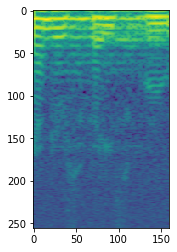

In [216]:
plt.imshow(x[index,:lens[index]].T)

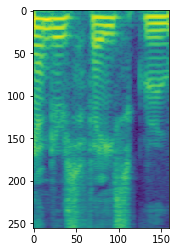

In [217]:
plt.imshow(x[index,:lens[index]].T + y[index,:lens[index]].T)

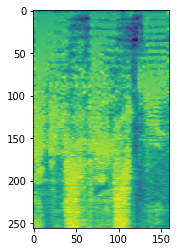

In [218]:
plt.imshow(y[index,:lens[index]].T)

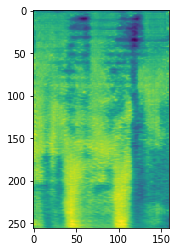

In [219]:
plt.imshow(logits[0,:lens[index],:,0].T)

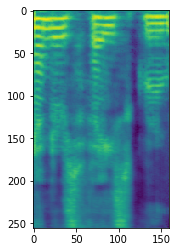

In [220]:
plt.imshow(x[index,:lens[index]].T + logits[0,:lens[index],:,0].T)

In [221]:
s_ = to_signal(mel_to_spectrogram(unscale_mel(x[index,:lens[index]].T)))
s = to_signal(mel_to_spectrogram(unscale_mel(x[index,:lens[index]].T + (y[index,:lens[index]].T))))

In [222]:
l = to_signal(mel_to_spectrogram(unscale_mel(x[index,:lens[index]].T + logits[0,:lens[index],:,0].T)))

In [223]:
import IPython.display as ipd

In [224]:
ipd.Audio(s, rate = 16000)

In [225]:
ipd.Audio(s_, rate = 16000)

In [226]:
ipd.Audio(l, rate = 16000)